In [1]:
'''
COMP3800 Mining Social Media
'''

import numpy as np
import nltk
import pandas as pd
import sklearn as sk
import re
import matplotlib.pyplot as plt
import wordcloud as wc
import spacy
import seaborn as sns
from collections import Counter
from textblob import TextBlob
import os
import glob
from scipy.stats import pearsonr



SEED = 3800
np.random.seed(SEED)
sk.utils.check_random_state(SEED)
pd.options.mode.chained_assignment = None

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer 
from textblob import TextBlob
from datetime import datetime

__author__ = 'Thomas Lamont'
__version__ = 'Fall 2024'

In [2]:
file_path = 'data/comp3800f24_tweets.csv'

columns_to_keep = [
    'id', 'url', 'twitterUrl', 'text', 'source', 'retweetCount', 'replyCount',
    'likeCount', 'quoteCount', 'viewCount', 'createdAt', 'lang', 'bookmarkCount',
    'isReply', 'inReplyToId', 'conversationId', 'inReplyToUsername', 'isPinned',
    'isRetweet', 'isConversationControlled'
]

try:

    df = pd.read_csv(file_path, usecols=columns_to_keep)
    
    print(f"DataFrame shape: {df.shape}")

    df = df.dropna(subset=['id'])
    df = df.drop_duplicates(subset=['id'])


    twitter_df = df
except Exception as e:
    print(f"Error processing file: {e}")

DataFrame shape: (57152, 20)


C:\Users\local_tl00162\Temp\ipykernel_8604\2051829243.py:12: DtypeWarning: Columns (5,6,7,8,9,12,13,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, usecols=columns_to_keep)


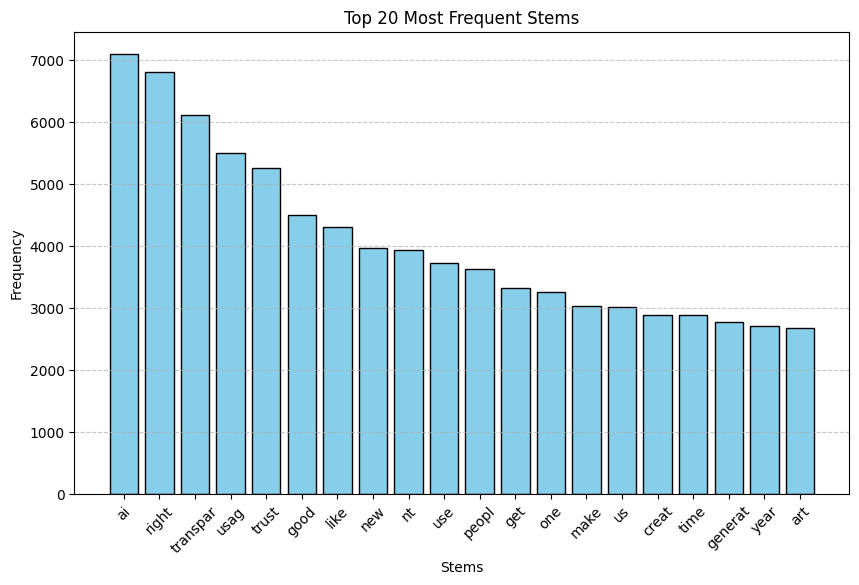

<Figure size 640x480 with 0 Axes>

In [3]:
twitter = twitter_df

tweets = twitter['text'].tolist()
text = ' '.join(tweets)

tokens = nltk.word_tokenize(text, language='english', preserve_line=True)
words = [re.sub(r'[^A-Za-z0-9]+', '', token) for token in tokens if token]
stops = set(stopwords.words('english'))

terms = [word for word in words if word.lower() not in stops]

stemmer = SnowballStemmer(language='english')
stems = [stemmer.stem(word) for word in terms]

stem_freq_dist = nltk.FreqDist(stems)

for unwanted_stem in ['https', 'amp', '']:
    if unwanted_stem in stem_freq_dist:
        stem_freq_dist.pop(unwanted_stem)

df_words = pd.DataFrame(list(stem_freq_dist.items()), columns=['stem', 'freq'])
df_sorted = df_words.sort_values(by=['freq'], ascending=False)

top_stems = df_sorted.head(20)  
plt.figure(figsize=(10, 6))
plt.bar(top_stems['stem'], top_stems['freq'], color='skyblue', edgecolor='black')
plt.title('Top 20 Most Frequent Stems')
plt.xlabel('Stems')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
#plt.savefig('images/plot1.png')
plt.show()


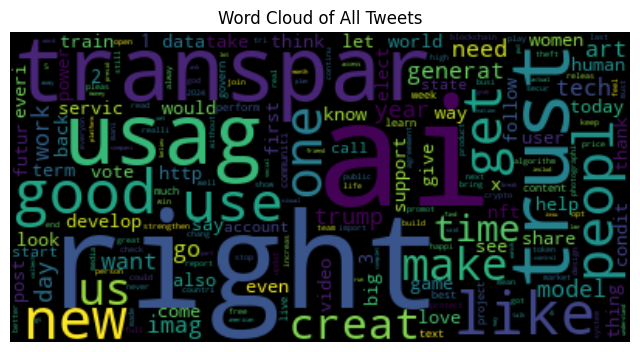

<Figure size 640x480 with 0 Axes>

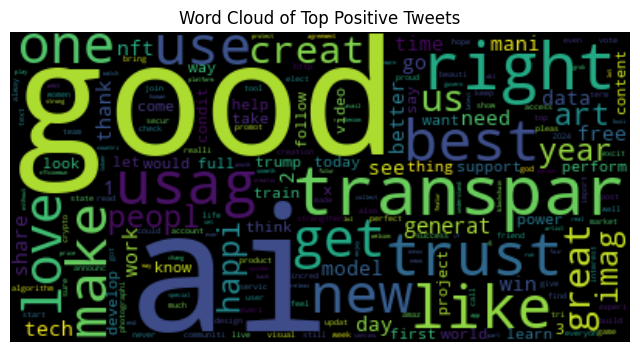

<Figure size 640x480 with 0 Axes>

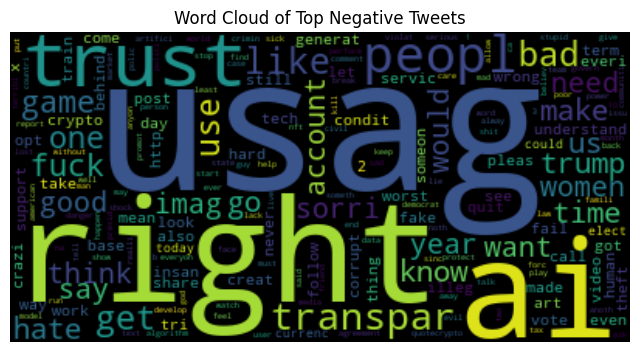

<Figure size 640x480 with 0 Axes>

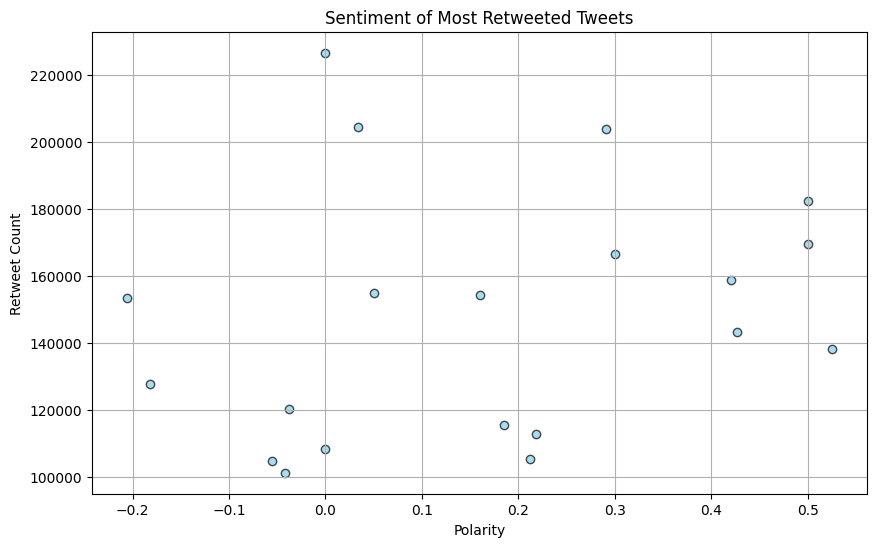

<Figure size 640x480 with 0 Axes>

In [4]:
stem_freq_dist = nltk.FreqDist(stems)

for unwanted_stem in ['https', 'amp', '', 'nt']:
    if unwanted_stem in stem_freq_dist:
        stem_freq_dist.pop(unwanted_stem)

wordcloud = wc.WordCloud().generate_from_frequencies(dict(stem_freq_dist))
plt.figure(figsize=(8, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Tweets')
#plt.savefig('images/plot2.png')
plt.show()


twitter['polarity'] = twitter['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
twitter['subjectivity'] = twitter['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

twitter['retweetCount'] = pd.to_numeric(twitter['retweetCount'], errors='coerce')

most_retweeted = twitter.sort_values(by='retweetCount', ascending=False).head(20)

positive_tweets = twitter[twitter['polarity'] > 0.25]['text']
negative_tweets = twitter[twitter['polarity'] < -0.25]['text']

def generate_wordcloud(tweets, title, saveto):
    all_text = ' '.join(tweets)
    tokens = nltk.word_tokenize(all_text, language='english', preserve_line=True)
    words = [re.sub(r'[^A-Za-z0-9]+', '', token) for token in tokens if token]
    terms = [word for word in words if word.lower() not in stops]
    stems = [stemmer.stem(word) for word in terms]
    freq_dist = nltk.FreqDist(stems)
    
    for unwanted_stem in ['https', 'amp', '', 'nt']:
        if unwanted_stem in freq_dist:
            freq_dist.pop(unwanted_stem)
    
    wordcloud = wc.WordCloud().generate_from_frequencies(dict(freq_dist))
    plt.figure(figsize=(8, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    #plt.savefig(saveto)
    plt.show()


generate_wordcloud(positive_tweets, "Word Cloud of Top Positive Tweets", 'images/plot3.png')

generate_wordcloud(negative_tweets, "Word Cloud of Top Negative Tweets", 'images/plot4.png')

plt.figure(figsize=(10, 6))
plt.scatter(most_retweeted['polarity'], most_retweeted['retweetCount'], alpha=0.7, c='skyblue', edgecolors='black')
plt.title('Sentiment of Most Retweeted Tweets')
plt.xlabel('Polarity')
plt.ylabel('Retweet Count')
plt.grid(True)
#plt.savefig('images/plot5.png')
plt.show()


C:\Users\local_tl00162\Temp\ipykernel_8604\2918643289.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  twitter['createdAt'] = pd.to_datetime(twitter['createdAt'], errors='coerce')
C:\Users\local_tl00162\Temp\ipykernel_8604\2918643289.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  twitter['week'] = twitter['createdAt'].dt.to_period('W').dt.start_time


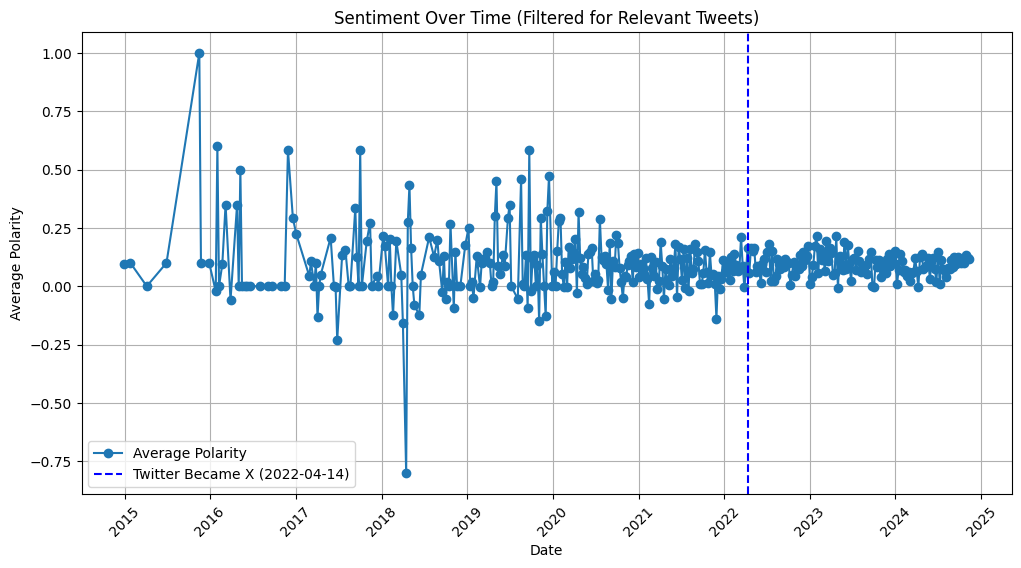

<Figure size 640x480 with 0 Axes>

In [5]:
twitter['createdAt'] = pd.to_datetime(twitter['createdAt'], errors='coerce')

keywords = ['X', 'Grok', 'ai', 'nft']
filtered_tweets = twitter[twitter['text'].str.contains('|'.join(keywords), case=False, na=False)]

filtered_tweets['polarity'] = filtered_tweets['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

filtered_tweets['date'] = filtered_tweets['createdAt'].dt.date

twitter['week'] = twitter['createdAt'].dt.to_period('W').dt.start_time

weekly_sentiment = twitter.groupby('week')['polarity'].mean().reset_index()

plt.figure(figsize=(12, 6))
plt.plot(weekly_sentiment['week'], weekly_sentiment['polarity'], marker='o', label='Average Polarity')

plt.axvline(pd.to_datetime('2022-04-14'), color='blue', linestyle='--', label='Twitter Became X (2022-04-14)')

plt.title('Sentiment Over Time (Filtered for Relevant Tweets)')
plt.xlabel('Date')
plt.ylabel('Average Polarity')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
#plt.savefig('images/plot6.png')
plt.show()



Mean Engagement Metrics by Polarization (Filtered by Keywords):
                 replyCount  retweetCount    likeCount  quoteCount  \
polarization                                                         
Highly Negative  223.727928   1138.762162  7977.046847  146.499099   
Neutral          194.190790    687.892218  3517.393795   80.829048   
Highly Positive  194.961700    629.709339  3007.350472   60.167366   

                     viewCount  
polarization                    
Highly Negative  569180.036036  
Neutral          292721.552157  
Highly Positive  275086.506296  


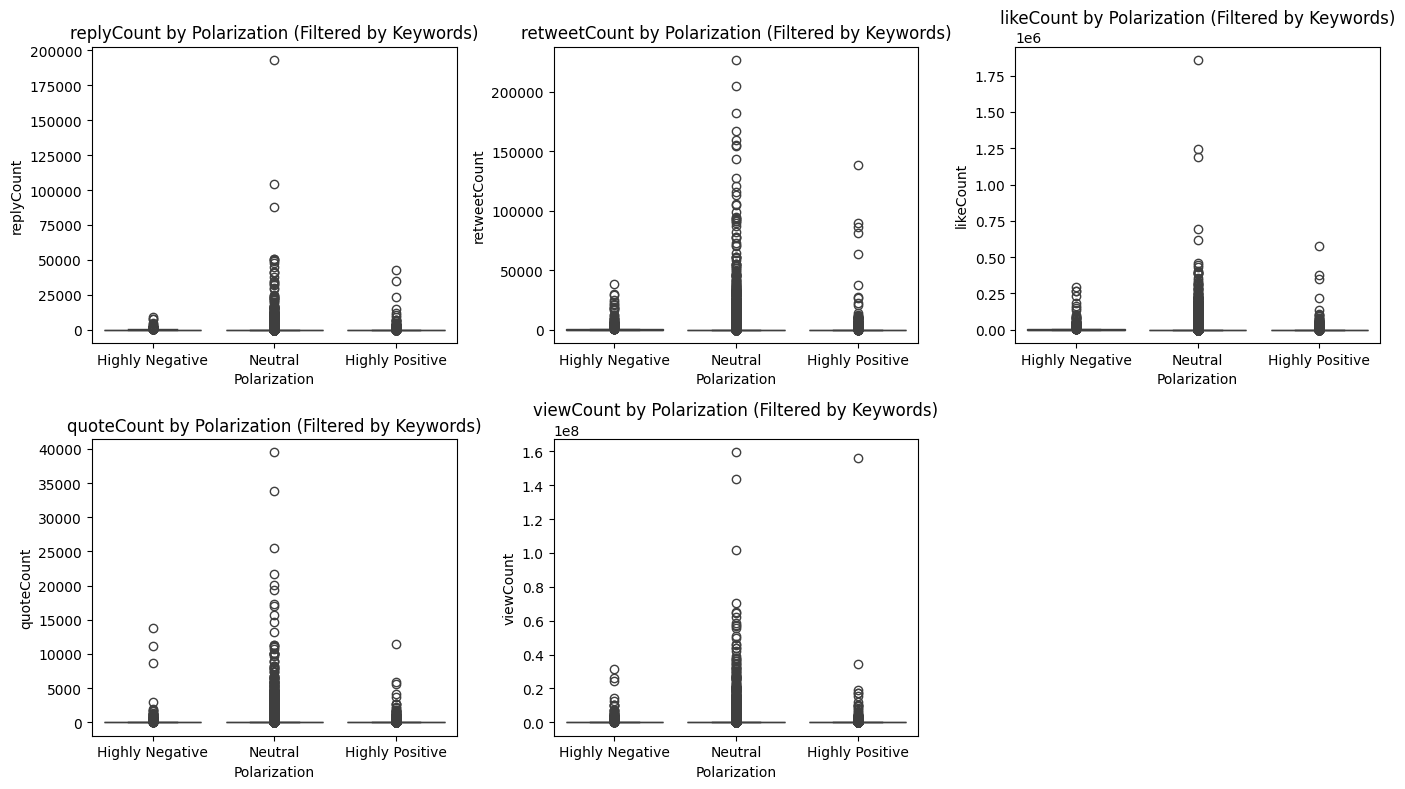


Correlation Between Polarity and Engagement Metrics (Filtered by Keywords):
replyCount: Pearson Correlation = -0.00, P-value = 0.7589
retweetCount: Pearson Correlation = -0.01, P-value = 0.0164
likeCount: Pearson Correlation = -0.03, P-value = 0.0000
quoteCount: Pearson Correlation = -0.02, P-value = 0.0002
viewCount: Pearson Correlation = -0.01, P-value = 0.0062


<Figure size 640x480 with 0 Axes>

In [6]:
keywords = ['X', 'Grok', 'ai', 'nft']

twitter['polarity'] = twitter['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

engagement_metrics = ['replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'viewCount']
for feature in engagement_metrics:
    twitter[feature] = pd.to_numeric(twitter[feature], errors='coerce')

twitter_cleaned = twitter.dropna(subset=engagement_metrics + ['polarity'])

filtered_twitter = twitter_cleaned[twitter_cleaned['text'].str.contains('|'.join(keywords), case=False, na=False)]

positive_threshold = 0.5
negative_threshold = -0.5

filtered_twitter['polarization'] = pd.cut(
    filtered_twitter['polarity'],
    bins=[-float('inf'), negative_threshold, positive_threshold, float('inf')],
    labels=['Highly Negative', 'Neutral', 'Highly Positive']
)

grouped = filtered_twitter.groupby('polarization', observed=False)[engagement_metrics].mean()
print("Mean Engagement Metrics by Polarization (Filtered by Keywords):")
print(grouped)

plt.figure(figsize=(14, 8))
for i, metric in enumerate(engagement_metrics, start=1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='polarization', y=metric, data=filtered_twitter)
    plt.title(f'{metric} by Polarization (Filtered by Keywords)')
    plt.xlabel('Polarization')
    plt.ylabel(metric)
plt.tight_layout()
#plt.savefig('images/plot7.png')
plt.show()


print("\nCorrelation Between Polarity and Engagement Metrics (Filtered by Keywords):")
for metric in engagement_metrics:
    corr, p_value = pearsonr(filtered_twitter['polarity'], filtered_twitter[metric])
    print(f"{metric}: Pearson Correlation = {corr:.2f}, P-value = {p_value:.4f}")


Mean Engagement Metrics by Polarization (NFT Tweets Only):
                 replyCount  retweetCount    likeCount  quoteCount  \
polarization                                                         
Highly Negative   49.812500    112.375000   396.812500    7.000000   
Neutral          465.682192    726.931507  1372.789726   30.846575   
Highly Positive  314.558974    248.235897   478.502564   26.579487   

                    viewCount  
polarization                   
Highly Negative   1325.062500  
Neutral          53991.713014  
Highly Positive   7752.287179  


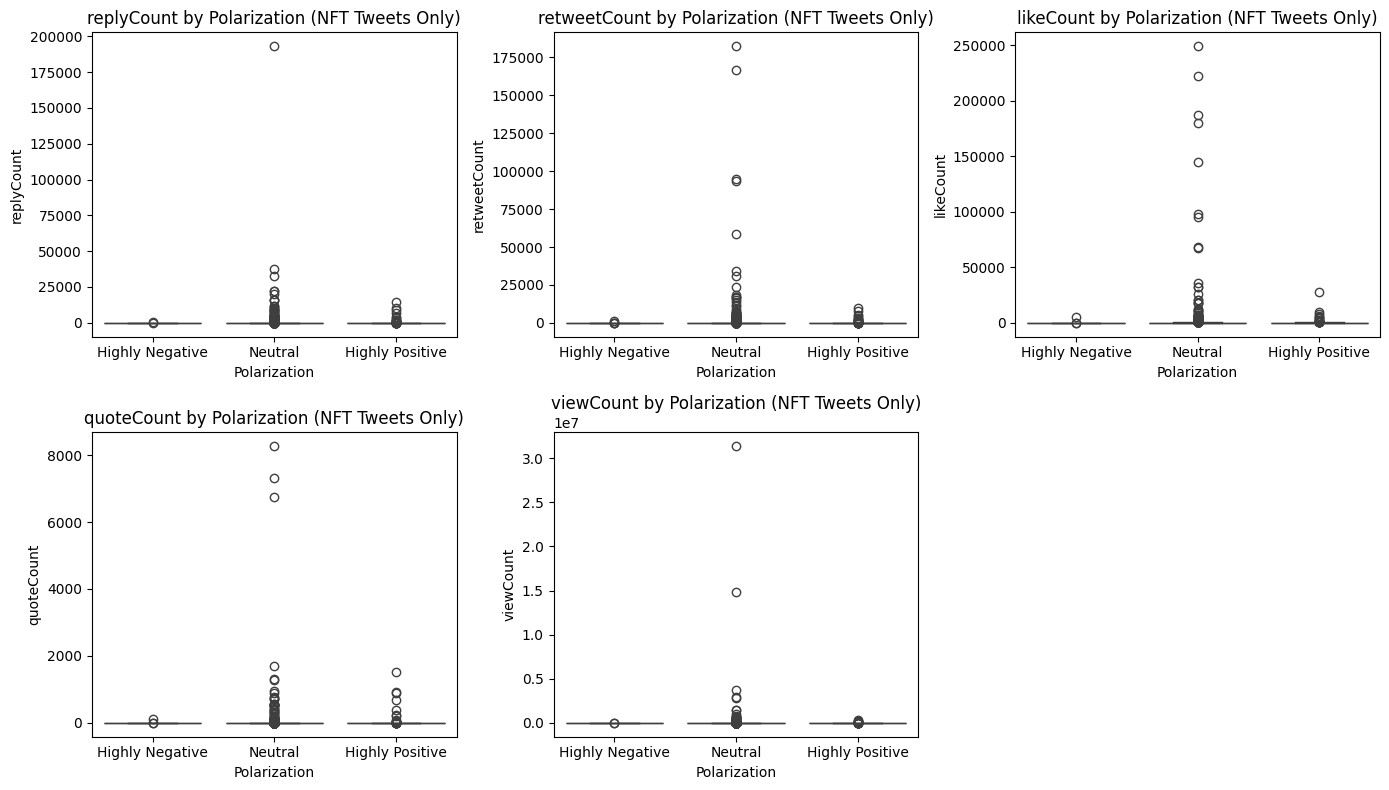


Correlation Between Polarity and Engagement Metrics (NFT Tweets Only):
replyCount: Pearson Correlation = 0.02, P-value = 0.5381
retweetCount: Pearson Correlation = 0.02, P-value = 0.3188
likeCount: Pearson Correlation = 0.02, P-value = 0.5224
quoteCount: Pearson Correlation = 0.03, P-value = 0.2169
viewCount: Pearson Correlation = 0.01, P-value = 0.6877


<Figure size 640x480 with 0 Axes>

In [7]:
twitter['polarity'] = twitter['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

engagement_metrics = ['replyCount', 'retweetCount', 'likeCount', 'quoteCount', 'viewCount']
for feature in engagement_metrics:
    twitter[feature] = pd.to_numeric(twitter[feature], errors='coerce')

twitter_cleaned = twitter.dropna(subset=engagement_metrics + ['polarity'])

nft_tweets = twitter_cleaned[twitter_cleaned['text'].str.contains('nft', case=False, na=False)]

positive_threshold = 0.5
negative_threshold = -0.5

nft_tweets['polarization'] = pd.cut(
    nft_tweets['polarity'],
    bins=[-float('inf'), negative_threshold, positive_threshold, float('inf')],
    labels=['Highly Negative', 'Neutral', 'Highly Positive']
)

grouped = nft_tweets.groupby('polarization', observed=False)[engagement_metrics].mean()
print("Mean Engagement Metrics by Polarization (NFT Tweets Only):")
print(grouped)

plt.figure(figsize=(14, 8))
for i, metric in enumerate(engagement_metrics, start=1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='polarization', y=metric, data=nft_tweets)
    plt.title(f'{metric} by Polarization (NFT Tweets Only)')
    plt.xlabel('Polarization')
    plt.ylabel(metric)
plt.tight_layout()
#plt.savefig('images/plot8.png')
plt.show()


print("\nCorrelation Between Polarity and Engagement Metrics (NFT Tweets Only):")
for metric in engagement_metrics:
    corr, p_value = pearsonr(nft_tweets['polarity'], nft_tweets[metric])
    print(f"{metric}: Pearson Correlation = {corr:.2f}, P-value = {p_value:.4f}")
